In [127]:
import pandas as pd
import seaborn as sns 
import matplotlib as plt
import numpy as np
import math
import sklearn

### Load in Data

In [2]:
window_data = pd.read_csv("data/first_31dbs_counters_string_time_data.csv")
immersive_data = pd.read_csv("data/first_31dbs_isImmersive_data.csv")

In [3]:
#joined tables on the time according to rows in the window data
data = window_data.merge(immersive_data, on = "time", how = 'left')

#data clean
data = data[data.is_immersive != -9.223372036854776e+18] #happens only 5 times in the data
data.head(3)

,time,window,is_immersive
0,2021-11-12 18:17:47.026,cmd.exe,0.0
1,2021-11-12 18:17:54.031,SearchApp.exe,1.0
2,2021-11-12 18:18:16.046,cmd.exe,0.0


In [4]:
data.shape

(4810, 3)

### Transition Matrix

In [5]:
window_order = list(data.window.unique())

In [6]:
#returns list of windows that come after param win (str)
def get_next_window(win, df): 
    windows_after_win = []
    for i in range(len(df) - 1): #-1 so it doesnt run on last entry
        #if current window is win
        if df['window'].iloc[i] == win:
            #doesn't matter what window is next, just log next window
            windows_after_win.append(df['window'].iloc[i+1])        
    return windows_after_win

In [7]:
#returns series of conditional probs for succeeding window(s) for a given win
def get_cond_probs(win,df):
    temp_windows = pd.Series(get_next_window(win, df))
    return temp_windows.value_counts() / temp_windows.value_counts().sum()

In [8]:
#creating the n x n transistion matrix
#n = num of unique windows
#indeces is the order of window_order

trans_matrix = []
for curr_win in window_order:
    curr_row  = [0] * len(window_order)
    probs = get_cond_probs(curr_win, data)
    probs_dict = dict(probs)
    for win in probs.index:
        prob = probs_dict[win]
        i = window_order.index(win)
        curr_row[i] = prob
    trans_matrix.append(curr_row)

In [9]:
#returns transisiton matrix for the HMM 
#creates the n x n transistion matrix
#n = num of unique windows
#indeces is the order of window_order
#rows denote prob for window_order[win] for every other window

def transition_matrix(data):
    window_order = list(data.window.unique())
    trans_matrix = []
    for curr_win in window_order:
        curr_row  = [0] * len(window_order)
        probs = get_cond_probs(curr_win, data)
        probs_dict = dict(probs)
        for win in probs.index:
            prob = probs_dict[win]
            i = window_order.index(win)
            curr_row[i] = prob
        trans_matrix.append(curr_row)
    return trans_matrix

In [10]:
# print(transition_matrix(data))

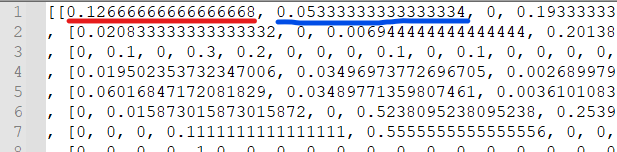

The output is an n x n matrix. In our case it's a 53 x 53 matrix. 
<br> It's read col-wise. In other words, a number is the probability that number's **col** appears **after** that number's **row**.
<br> For example, 0.126...(red underline) is the probability that col 1 (cmd.exe) appears after row 1 (cmd.exe).
<br> Likewise, 0.053...(blue underline) is the probability that col 2 (SearchApp.exe) appears after row 1 (cmd.exe)

In [11]:
#First 2 windows of window_order
window_order[:2]

['cmd.exe', 'SearchApp.exe']

### Emission Matrix

In [12]:
def get_immersive_prob(win, data):
    win_data = data[data.window == win]
    total_is_immersive = win_data.is_immersive.value_counts().sum() #this doesn't count values of NaN
    num_immersive = len(win_data[win_data.is_immersive == 1])
    return num_immersive / total_is_immersive

In [13]:
# Create the immersive row for the emission matrix which just a 1 x 53 matrix for now
is_immersive_row = []
for win in window_order:
    is_immersive_row.append(get_immersive_prob(win, data))

C:\Users\Andrew Chin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars
  """


In [14]:
print(is_immersive_row)

[0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, nan, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, nan]


Seems like there are nan values in the matrix so lets take a closer look

In [15]:
#last value is a nan, lets see what window that is
window_order[-1]

'spotify_installer-1.1.76.447.g11f432d8-14.exe'

In [16]:
data[data.window == 'spotify_installer-1.1.76.447.g11f432d8-14.exe']#.is_immersive.value_counts(dropna = False)

,time,window,is_immersive
4576,2022-01-11 19:16:59.779,spotify_installer-1.1.76.447.g11f432d8-14.exe,NaN


Since some windows have only NaNs as an is_immersive value, they will be manually changed to 0s since the majority of windows are not Windows Store applications.

In [17]:
type(is_immersive_row[-1])

numpy.float64

In [18]:
#replacing the row with 0 if the probability is NaN
is_immersive_row = [0.0 if math.isnan(x) else x for x in is_immersive_row]
print(is_immersive_row)

[0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


In [19]:
#takes in to account only the immersive prob 
#will be altered to fit multiple objective features
def emission_matrix(data):
    window_order = list(data.window.unique())
    emis_matrix = []
    for win in window_order:
        emis_matrix.append(get_immersive_prob(win, data))
    emis_matrix = [0.0 if math.isnan(x) else x for x in emis_matrix]
    return [emis_matrix]  

In [20]:
print(emission_matrix(data))

C:\Users\Andrew Chin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars
  """


[[0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]]


## Predictor

Now, let't build the predictor. Essentially, we will be predicting which app will come after a given app. We do this by picking the top 5 highest probabilities from our transition matrix. 
<br> The window_order is essential as it allows us to track the indeces of the transition and emission matrices

In [30]:
print(window_order), print("\nNumber of rows and cols:"), print(len(window_order))

['cmd.exe', 'SearchApp.exe', 'notepad++.exe', 'chrome.exe', 'explorer.exe', 'ApplicationFrameHost.exe', 'Code.exe', 'CodeSetup-stable-3a6960b964327f0e3882ce18fcebd07ed191b316.tmp', 'Teams.exe', 'LockApp.exe', 'devenv.exe', 'HxOutlook.exe', 'EXCEL.EXE', 'ShellExperienceHost.exe', 'OpenWith.exe', 'notepad.exe', 'Microsoft.AAD.BrokerPlugin.exe', 'Spotify.exe', 'python.exe', 'Discord.exe', 'DB Browser for SQLite.exe', 'WINWORD.EXE', '7zG.exe', 'ScreenClippingHost.exe', 'msedge.exe', 'mmc.exe', 'Zoom.exe', 'SystemSettings.exe', 'Taskmgr.exe', 'StartMenuExperienceHost.exe', 'VsDebugConsole.exe', 'world_of_tanks_install_na_cftbfe6fxhhv.tmp', 'world_of_tanks_install_na_cftbfe6fxhhv (1).tmp', 'wgc_renderer_host.exe', 'wgc.exe', 'PickerHost.exe', 'atom.exe', 'Microsoft.Photos.exe', 'WindowsCamera.exe', 'Docker Desktop.exe', 'SystemSettingsAdminFlows.exe', 'vpnui.exe', 'world_of_tanks_install_na_cga3n2xecmlf.tmp', 'WorldOfTanks.exe', 'spotify_installer-1.1.73.517.gbef50fdb-23.exe', 'msoasb.exe', 

(None, None, None)

In [23]:
temp_trans_matrix = transition_matrix(data)

In [39]:
temp_trans_df = pd.DataFrame(temp_trans_matrix)
temp_trans_df.columns = window_order
temp_trans_df.index = window_order
temp_trans_df.head()

,cmd.exe,SearchApp.exe,notepad++.exe,chrome.exe,explorer.exe,ApplicationFrameHost.exe,Code.exe,CodeSetup-stable-3a6960b964327f0e3882ce18fcebd07ed191b316.tmp,Teams.exe,LockApp.exe,...,WorldOfTanks.exe,spotify_installer-1.1.73.517.gbef50fdb-23.exe,msoasb.exe,CodeSetup-stable-899d46d82c4c95423fb7e10e68eba52050e30ba3.tmp,rundll32.exe,HxCalendarAppImm.exe,spotify_installer-1.1.74.631.g0b24d9ad-16.exe,Installer.exe,zCefAgent.exe,spotify_installer-1.1.76.447.g11f432d8-14.exe
cmd.exe,0.126667,0.053333,0.000000,0.193333,0.400000,0.006667,0.000000,0.000000,0.040000,0.013333,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
SearchApp.exe,0.020833,0.000000,0.006944,0.201389,0.159722,0.138889,0.000000,0.000000,0.020833,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
notepad++.exe,0.000000,0.100000,0.000000,0.300000,0.200000,0.000000,0.000000,0.000000,0.100000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
chrome.exe,0.019542,0.035040,0.002695,0.186658,0.161725,0.012803,0.000674,0.000000,0.048518,0.072102,...,0.004717,0.000000,0.000674,0.0,0.0,0.000674,0.000674,0.000674,0.000000,0.000000
explorer.exe,0.060241,0.034940,0.003614,0.395181,0.004819,0.014458,0.006024,0.001205,0.103614,0.030120,...,0.000000,0.001205,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.001205,0.001205


In [40]:
data.window.iloc[0]

'cmd.exe'

In [42]:
temp_transemis_matrix = transition_matrix(data) + emission_matrix(data)

C:\Users\Andrew Chin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars
  """


In [106]:
def clean_data(data):

    #clean is_immersive column
    
    #get specific nan float value
    is_NaN = data.isnull()
    row_has_NaN = is_NaN.any(axis=1)
    rows_with_NaN = data[row_has_NaN]
    nan_value = rows_with_NaN.iloc[0,0]
    #get rid of any number other than 0, 1 or nan value
    data = data[data.is_immersive.isin([0,1,nan_value])]
    return data

In [ ]:
def fit(self, X, y):
    # Check that X and y have correct shape
    X, y = check_X_y(X, y)
    # Store the classes seen during fit
    self.classes_ = unique_labels(y)

    self.X_ = X
    self.y_ = y
    # Return the classifier
    return self

In [120]:
data.head()

,time,window,is_immersive
0,2021-11-12 18:17:47.026,cmd.exe,0.0
1,2021-11-12 18:17:54.031,SearchApp.exe,1.0
2,2021-11-12 18:18:16.046,cmd.exe,0.0
3,2021-11-12 18:18:21.052,SearchApp.exe,1.0
4,2021-11-12 18:18:50.083,notepad++.exe,0.0


In [126]:
"""
Splits data into train and test portions, default 80-20 split
Training data is first train_size % of the data
Test data is last test_size % of the data
@params: data df to split 
         train_size float percentage of data to be training set
         test_size float percentage of data to be test set
@return: 2 dfs (train and test dfs)
"""
def train_test_split(data,train_size = .8, test_size = .2):
    len_train_data = train_size * len(data)
    len_test_size = test_size * len(data)
    train_data = data[:int(len_train_data)]
    test_data = data[len(data) - int(len_test_size):]
    return train_data, test_data

In [138]:
'cmd.exe' in (temp_trans_df.index)

True

In [165]:
#This predictor outputs the top x probable windows and checks the current test data window if it's in the top x.
#if not then a check mark of incorrect is added 
#accuracy is outputted at the end
def predictor1(train, test): #(self, X)
    window_order = list(train.window.unique())
    #Create transition matrix (store as df for easier indexing) ~ made on train data
    trans_matrix = pd.DataFrame(transition_matrix(train))
    trans_matrix.columns = window_order
    trans_matrix.index = window_order
     
    num_correct = 0
    
    #Start from the very first window
    for i in range(len(test.window) - 1): # -1 to not go past the last row
        win = test.window.iloc[i]
        next_win = test.window.iloc[i+1]
        
        #make sure win is an index of the matrix
        if win in window_order:
            win_index = window_order.index(win)
            probs = trans_matrix.loc[win]
            #setting it as top 5, will be change d depending on accuracy
            top_prob_wins = probs.sort_values(ascending = False)[:5].index
            #check if the next window is within the threshold
            if next_win in top_prob_wins:
                num_correct +=1
        # if window is NOT in matrix, check to see if next window is part of the top 5 most common windows
        # if so, then its a correct prediction
        else:
            top_windows = train.window.value_counts(ascending = False)[:5].index
            if next_win in top_windows:
                num_correct +=1
                
    return num_correct / (len(test.window) - 1) # -1 so that we dont guess the last window's next window(?)

In [190]:
#This predictor ouputs a sequence of next windows. Accuracy is measured AFTER 
def predictor2(train,test): #(self, X)
    window_order = list(train.window.unique())
    #Create transition matrix (store as df for easier indexing)
    trans_matrix = pd.DataFrame(transition_matrix(train))
    trans_matrix.columns = window_order
    trans_matrix.index = window_order
    
    starting_window = test.window.iloc[0]
    next_windows = []
    
    #loop through len(data) - 1 since we already have the first window
    for win in test.window[1:]:
        #if win is an index of the matrix
        if win in window_order:
            win_index = window_order.index(win)
            probs = trans_matrix.loc[win]
            next_win = probs.idxmax()
            next_windows.append(next_win)
        #if win is not in the matrix's indeces,
        #we weill predict next window to be the most common window of train data
        else:
            next_win = train.window.value_counts().idxmax()
            next_windows.append(next_win)
            
    return next_windows

In [222]:
#This predictor outputs the top x probable windows and 
#checks the current test data window if it's in the top x AND fits is_immersive emission matrix value
#if not then a check mark of incorrect is added 
#accuracy is outputted at the end

def predictor3(train, test): #(self, X)

    window_order = list(train.window.unique())
    #Create transition matrix (store as df for easier indexing)
    trans_matrix = pd.DataFrame(transition_matrix(train) + emission_matrix(train))
    trans_matrix.columns = window_order
    trans_matrix.index = window_order + ['is_immersive'] #add immersive label for the row-wise index
    
    num_correct = 0
    #Start from the very first window
    for i in range(len(test.window) - 1): # -1 to not go past last row
        #if win is an index of the matrix
        win = test.window.iloc[i]
        win_imm = test.is_immersive.iloc[i] #might be problems with nan values; havent checked it out yet
        next_win = test.window.iloc[i+1]
        next_win_imm = test.is_immersive.iloc[i]
        
        if win in window_order:
            win_index = window_order.index(win)
            probs = trans_matrix.loc[win]
            #setting it as top 5, will be changed depending on accuracy
            top_prob_wins = probs.sort_values(ascending = False)[:5].index
            #check if the next window is within the threshold AND if they're immersive
            #the immersive part is redundant since its just binary values that are always related to the its respectable window
            if (next_win in top_prob_wins) and (next_win_imm == trans_matrix.loc['is_immersive', next_win]):
                num_correct +=1
        # if window is NOT in matrix, check to see if next window is part of the top 5 most common windows
        # will also check if it is the is_immersive value of the most common value
        #ex. if train data has more 0 is_immersive than 1, then we will make 0 the "is correct" condition
        # if so, then its a correct prediction
        else:
            top_windows = train.window.value_counts(ascending = False)[:5].index
            immersive_value = data.is_immersive.value_counts().idxmax()
            if (next_win in top_windows) and (next_win_imm == immersive_value):
                num_correct +=1
                
    return num_correct / (len(test.window) - 1)

In [176]:
data.is_immersive.value_counts()

0.0    2851
1.0    1428
Name: is_immersive, dtype: int64

## Testing Accuracy

### Splitting Data

In [177]:
"""
Splits data into train and test portions, default 80-20 split
Training data is first train_size % of the data
Test data is last test_size % of the data
@params: data df to split 
         train_size float percentage of data to be training set
         test_size float percentage of data to be test set
@return: 2 dfs (train and test dfs)
"""
def train_test_split(data,train_size = .8, test_size = .2):
    len_train_data = train_size * len(data)
    len_test_size = test_size * len(data)
    train_data = data[:int(len_train_data)]
    test_data = data[len(data) - int(len_test_size):]
    return train_data, test_data

In [178]:
train_data, test_data = train_test_split(data, train_size=.8)

In [171]:
len(train_data) + len(test_data) == len(data)

True

### Predictor 1

In [172]:
print("Accuaracy for predictor1 is: " + str(predictor1(train_data, test_data)))

Accuaracy for predictor1 is: 0.6711758584807492


### Predictor 2

In [221]:
predicted_window_sequence = predictor2(train_data, test_data)

In [219]:
num_correct = 0
for i in range(len(test_data.window) - 1):
    if test_data.window.iloc[i] == predicted_window_sequence[i]:
        num_correct += 1
num_correct / len(test_data)

0.2796257796257796

### Predictor 3

In [223]:
print("Accuaracy for predictor3 is: " + str(predictor3(train_data, test_data)))

C:\Users\Andrew Chin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars
  """


Accuaracy for predictor3 is: 0.17273673257023933
